## import & load

In [1]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

from collections import defaultdict
import datetime
import pytz
import importlib
import matplotlib.pyplot as plt

import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [2]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

In [3]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')
    os.environ["GOOGLE_CLOUD_PROJECT"] = "trading-290017"
else:
    print('the credential.json file does not exist')

import importlib

In [4]:
import market_data.ingest.bq.cache
importlib.reload(market_data.ingest.bq.cache)
importlib.reload(market_data.ingest.bq.candle)

<module 'market_data.ingest.bq.candle' from '/home/junlim/projects/jitter_recovery/market_data/ingest/bq/candle.py'>

In [29]:
date_str_from='2023-12-01'
date_str_to='2024-01-01'
dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX
export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE
df = market_data.ingest.bq.cache.fetch_and_cache(
    dataset_mode, 
    export_mode, 
    market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from=date_str_from, date_str_to=date_str_to)
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])

In [27]:
all_symbols = df.symbol.unique()
all_symbols = [s for s in all_symbols if s]
len([s for s in all_symbols if 'USDT' in s])

164

## calculate/cache features

In [5]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.collective_jitter_recovery.calculate
importlib.reload(algo.collective_jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)
import algo.collective_jitter_recovery.research
importlib.reload(algo.collective_jitter_recovery.research)
import algo.cache
importlib.reload(algo.cache)

<module 'algo.cache' from '/home/junlim/projects/jitter_recovery/algo/cache.py'>

In [6]:
feature_param = algo.collective_jitter_recovery.calculate.CollectiveRecoveryFeatureParam(window=40, collective_window=30)

In [9]:
algo.collective_jitter_recovery.research.get_feature_label_for_caching(feature_param)

'(collectivechanges)_window(40)_collective_window(30)'

In [10]:
import market_data.ingest.bq.common
dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX
export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE

In [31]:
dfst_feature = algo.cache.read_df(
    label = algo.collective_jitter_recovery.research.get_feature_label_for_caching(feature_param),
    dataset_mode=dataset_mode, 
    export_mode=export_mode, 
    date_str_from='2023-12-01', 
    date_str_to='2024-01-01')

In [116]:
dfst_feature

index    open    high     low  \
symbol         timestamp                                                    
1INCH-USD-SWAP 2024-02-29 00:00:00-05:00    41760  0.5124  0.5124  0.5124   
               2024-02-29 00:01:00-05:00    41761  0.5137  0.5137  0.5137   
               2024-02-29 00:02:00-05:00    41762  0.5137  0.5137  0.5137   
               2024-02-29 00:03:00-05:00    41763  0.5131  0.5131  0.5130   
               2024-02-29 00:04:00-05:00    41764  0.5128  0.5128  0.5128   
...                                           ...     ...     ...     ...   
ZRX-USDT-SWAP  2024-03-20 23:55:00-04:00  5948912  1.2200  1.2294  1.2200   
               2024-03-20 23:56:00-04:00  5948913  1.2291  1.2297  1.2215   
               2024-03-20 23:57:00-04:00  5948914  1.2226  1.2252  1.2220   
               2024-03-20 23:58:00-04:00  5948915  1.2229  1.2299  1.2228   
               2024-03-20 23:59:00-04:00  5948916  1.2286  1.2289  1.2241   

                                           close       volume  \
symbol         timestamp                                        
1INCH-USD-SWAP 2024-02-29 00:00:00-05:00  0.5124       0.0000   
               2024-02-29 00:01:00-05:00  0.5137     486.6654   
               2024-02-29 00:02:00-05:00  0.5137       0.0000   
               2024-02-29 00:03:00-05:00  0.5130     721.1564   
               2024-02-29 00:04:00-05:00  0.5128     468.0187   
...                                          ...          ...   
ZRX-USDT-SWAP  2024-03-20 23:55:00-04:00  1.2292   82220.0000   
               2024-03-20 23:56:00-04:00  1.2222  123640.0000   
               2024-03-20 23:57:00-04:00  1.2228   52060.0000   
               2024-03-20 23:58:00-04:00  1.2287   44780.0000   
               2024-03-20 23:59:00-04:00  1.2241   36200.0000   

                                          avg_v_before_max_ch  \
symbol         timestamp                                        
1INCH-USD-SWAP 2024-02-29 00:00:00-05:00                  NaN   
               2024-02-29 00:01:00-05:00                  NaN   
               2024-02-29 00:02:00-05:00                  NaN   
               2024-02-29 00:03:00-05:00                  NaN   
               2024-02-29 00:04:00-05:00                  NaN   
...                                                       ...   
ZRX-USDT-SWAP  2024-03-20 23:55:00-04:00             1.219475   
               2024-03-20 23:56:00-04:00             1.219833   
               2024-03-20 23:57:00-04:00             1.220211   
               2024-03-20 23:58:00-04:00             1.220554   
               2024-03-20 23:59:00-04:00             1.220831   

                                          avg_v_before_min_ch        ch  \
symbol         timestamp                                                  
1INCH-USD-SWAP 2024-02-29 00:00:00-05:00                  NaN       NaN   
               2024-02-29 00:01:00-05:00                  NaN       NaN   
               2024-02-29 00:02:00-05:00                  NaN       NaN   
               2024-02-29 00:03:00-05:00                  NaN       NaN   
               2024-02-29 00:04:00-05:00                  NaN       NaN   
...                                                       ...       ...   
ZRX-USDT-SWAP  2024-03-20 23:55:00-04:00             1.219205  0.019660   
               2024-03-20 23:56:00-04:00             1.219576  0.013853   
               2024-03-20 23:57:00-04:00             1.219967  0.012671   
               2024-03-20 23:58:00-04:00             1.220323  0.014951   
               2024-03-20 23:59:00-04:00             1.220609  0.010400   

                                            ch_max  ...  v_ch_min_is_to  \
symbol         timestamp                            ...                   
1INCH-USD-SWAP 2024-02-29 00:00:00-05:00       NaN  ...             NaN   
               2024-02-29 00:01:00-05:00       NaN  ...             NaN   
               2024-02-29 00:02:00-05:00       NaN  ...             NaN   

In [28]:
dfst_feature = algo.collective_jitter_recovery.research.get_dfst_feature(df, feature_param)

0 symbol: 1INCH-USDT-SWAP (feature)
1 symbol: AAVE-USDT-SWAP (feature)
2 symbol: ACE-USDT-SWAP (feature)
3 symbol: ADA-USDT-SWAP (feature)
4 symbol: AGIX-USDT-SWAP (feature)
5 symbol: AGLD-USDT-SWAP (feature)



KeyboardInterrupt



In [193]:
algo.cache.cache_df(
    dfst_feature, 
    label = algo.collective_jitter_recovery.research.get_feature_label_for_caching(feature_param),
    dataset_mode=dataset_mode, 
    export_mode=export_mode, 
    overwrite = True)

2024-03-30 18:57:31,025 [MainThread  ] [INFO ]  /home/junlim/feature_data/(collectivechanges)_window(40)_collective_window(30)/trading-290017.market_data_okx.by_minute_2024-03-12T00:00:00-0400_2024-03-13T00:00:00-0400.parquet already exists.
2024-03-30 18:57:31,026 [MainThread  ] [INFO ]  and would overwrite it.


## multiple symbols

In [13]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.collective_jitter_recovery.calculate
importlib.reload(algo.collective_jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)
import algo.collective_jitter_recovery.research
importlib.reload(algo.collective_jitter_recovery.research)
import algo.cache
importlib.reload(algo.cache)

<module 'algo.cache' from '/home/junlim/projects/jitter_recovery/algo/cache.py'>

In [9]:
trading_param = algo.collective_jitter_recovery.calculate.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.collective_jitter_recovery.calculate.CollectiveDropRecoveryTradingParam(
        -0.10, -0.30, -0.15, +0.04, -0.02),
    collective_jump_recovery_trading_param = None,
)

In [10]:
trading_param = algo.collective_jitter_recovery.calculate.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.collective_jitter_recovery.calculate.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.03, +0.005, -0.01),
    collective_jump_recovery_trading_param = None,
)

In [101]:
trading_param = algo.collective_jitter_recovery.calculate.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.collective_jitter_recovery.calculate.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.06, +0.03, -0.01),
    collective_jump_recovery_trading_param = None,
)

In [42]:
trading_param = algo.collective_jitter_recovery.calculate.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = None,
    collective_jump_recovery_trading_param = algo.collective_jitter_recovery.calculate.CollectiveJumpRecoveryTradingParam(
        0.03, 0.15, 0.03, -0.005, 0.01),
)

In [43]:
trading_param = algo.collective_jitter_recovery.calculate.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = None,
    collective_jump_recovery_trading_param = algo.collective_jitter_recovery.calculate.CollectiveJumpRecoveryTradingParam(
        0.03, 0.15, 0.06, -0.03, 0.01),
)

In [14]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.collective_jitter_recovery.calculate
importlib.reload(algo.collective_jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)
import algo.collective_jitter_recovery.research
importlib.reload(algo.collective_jitter_recovery.research)
import algo.cache
importlib.reload(algo.cache)

<module 'algo.cache' from '/home/junlim/projects/jitter_recovery/algo/cache.py'>

In [15]:
trading_param = algo.collective_jitter_recovery.calculate.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.collective_jitter_recovery.calculate.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.03, +0.005, -0.01),
    collective_jump_recovery_trading_param = None,
)

In [17]:
algo.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param)

'(collectivechanges_trading)_feature_param(window(40)_collective_window(30))_collective_drop_recovery_trading_param(collective_drop_threshold(-0.03)_collective_drop_lower_threshold(-0.3)_drop_threshold(-0.03)_jump_from_drop_threshold(0.005)/exit_drop_threshold(-0.01))_collective_jump_recovery_trading_param(None)'

In [32]:
dfst_trading = algo.collective_jitter_recovery.research.get_dfst_trading(dfst_feature, trading_param)

0 symbol: 1INCH-USDT-SWAP (365):(trading)
1 symbol: AAVE-USDT-SWAP (592):(trading)
2 symbol: ADA-USDT-SWAP (574):(trading)
3 symbol: AGIX-USDT-SWAP (550):(trading)
4 symbol: AGLD-USDT-SWAP (2031):(trading)
5 symbol: AIDOGE-USDT-SWAP (4855):(trading)
6 symbol: ALGO-USDT-SWAP (617):(trading)
7 symbol: ALPHA-USDT-SWAP (1373):(trading)
8 symbol: ANT-USDT-SWAP (39):(trading)
9 symbol: APE-USDT-SWAP (288):(trading)
10 symbol: API3-USDT-SWAP (713):(trading)
11 symbol: APT-USDT-SWAP (586):(trading)
12 symbol: AR-USDT-SWAP (749):(trading)
13 symbol: ARB-USDT-SWAP (678):(trading)
14 symbol: ATOM-USDT-SWAP (487):(trading)
15 symbol: AUCTION-USDT-SWAP (7994):(trading)
16 symbol: AVAX-USDT-SWAP (1079):(trading)
17 symbol: AXS-USDT-SWAP (634):(trading)
18 symbol: BADGER-USDT-SWAP (1565):(trading)
19 symbol: BAL-USDT-SWAP (231):(trading)
20 symbol: BAND-USDT-SWAP (781):(trading)
21 symbol: BAT-USDT-SWAP (212):(trading)
22 symbol: BCH-USDT-SWAP (231):(trading)
23 symbol: BICO-USDT-SWAP (648):(trading)

In [34]:
algo.cache.cache_df(
    dfst_trading, 
    label = algo.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode=dataset_mode, 
    export_mode=export_mode, 
    overwrite = True)

In [34]:
dfst_trading[dfst_trading.profit != 0][['profit']].dropna().groupby('symbol').sum().sort_values('profit')

,profit
symbol,
GPT-USDT-SWAP,-0.055931
ZRX-USDT-SWAP,-0.012409
CELO-USDT-SWAP,-0.011381
CTC-USDT-SWAP,-0.011131
XCH-USDT-SWAP,-0.010403
...,...
COMP-USDT-SWAP,0.078220
AGIX-USDT-SWAP,0.083966
JUP-USDT-SWAP,0.084245


In [35]:
len(dfst_trading[dfst_trading.profit != 0][['profit']].dropna().groupby('symbol').sum().sort_values('profit'))

171

<Axes: xlabel='timestamp'>

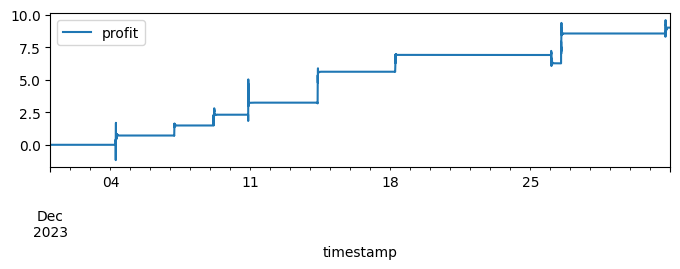

In [35]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

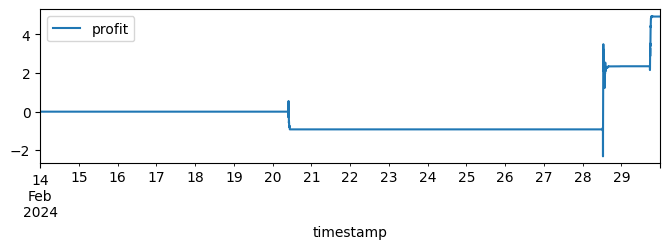

In [146]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [24]:
dfst_trading = algo.cache.read_df(
    label = algo.collective_jitter_recovery.research.get_trading_label_for_caching(trading_param),
    dataset_mode=dataset_mode, 
    export_mode=export_mode, 
    date_str_from='2024-02-29', 
    date_str_to='2024-03-21')

<Axes: xlabel='timestamp'>

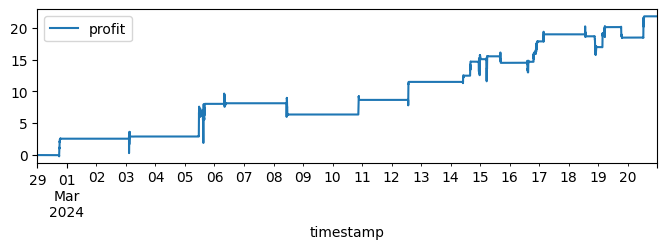

In [25]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [67]:
df_collective_feature = dfst_feature.dropna().groupby('timestamp')[
    collective_feature_columns_no_rolling].median().resample('1min').asfreq().ffill()
df_collective_feature['ch_std'] = dfst_feature.dropna().groupby('timestamp')[
        ['ch']].std().resample('1min').asfreq().ffill().values
df_collective_feature['ch_window30_min'] = df_collective_feature.ch.rolling(window=30).min()
df_collective_feature['ch_window30_max'] = df_collective_feature.ch.rolling(window=30).max()

In [75]:
df_collective_feature = algo.collective_jitter_recovery.research.get_df_collective_feature(dfst_feature)

In [76]:
df_collective_feature.columns

Index(['ch', 'ch_max', 'ch_min', 'ch_since_max', 'ch_since_min', 'ch_std',
       'ch_window30_min', 'ch_window30_max'],
      dtype='object')

<Axes: xlabel='timestamp'>

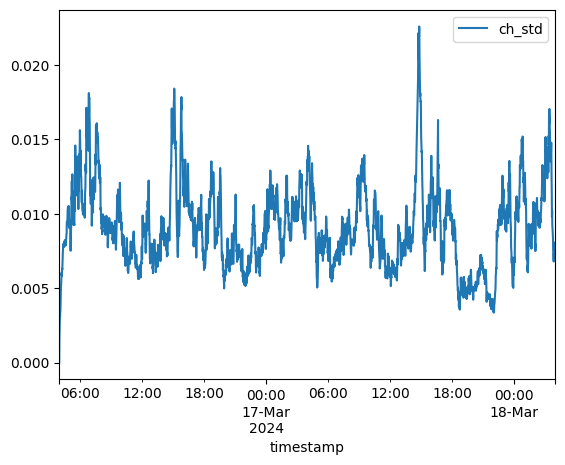

In [82]:
df_collective_feature[['ch_std']].plot()

In [79]:
dfst_with_collective_feature = algo.collective_jitter_recovery.research.append_collective_feature(df, dfst_feature)

In [80]:
dfst_with_collective_feature.columns

Index(['open', 'high', 'low', 'close', 'volume', 'avg_v_before_max_ch',
       'avg_v_before_min_ch', 'ch', 'ch_max', 'ch_min', 'ch_since_max',
       'ch_since_min', 'distance_max_ch', 'distance_min_ch',
       'v_ch_max_is_from', 'v_ch_max_is_to', 'v_ch_min_is_from',
       'v_ch_min_is_to', 'value', 'ch_collective', 'ch_max_collective',
       'ch_min_collective', 'ch_since_max_collective',
       'ch_since_min_collective', 'ch_std_collective',
       'ch_window30_min_collective', 'ch_window30_max_collective'],
      dtype='object')

In [85]:
dfst_with_collective_feature[
    (dfst_with_collective_feature.ch - dfst_with_collective_feature.ch_collective) > 0.10
].index.get_level_values('symbol').unique()

Index(['RAY-USDT-SWAP', 'YGG-USDT-SWAP', 'JOE-USDT-SWAP', 'ZRX-USDT-SWAP',
       'JUP-USDT-SWAP', 'SWEAT-USDT-SWAP', 'FRONT-USDT-SWAP',
       'DMAIL-USDT-SWAP', 'GPT-USDT-SWAP', 'LPT-USDT-SWAP', 'OM-USDT-SWAP',
       'FLR-USDT-SWAP', 'BONE-USDT-SWAP', 'MASK-USDT-SWAP'],
      dtype='object', name='symbol')

In [ ]:
dfst_with_collective_feature[
    (dfst_with_collective_feature.)
]

<Axes: xlabel='timestamp'>

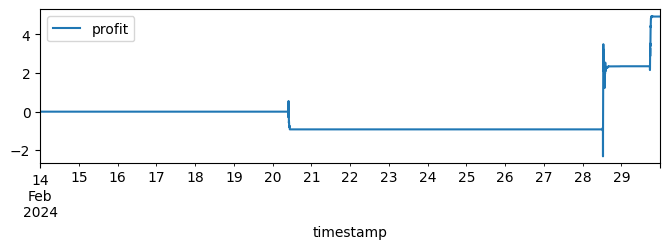

In [36]:
'''
trading_param = algo.collective_jitter_recovery.calculate.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.collective_jitter_recovery.calculate.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.03, +0.005, -0.01),
    collective_jump_recovery_trading_param = None,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

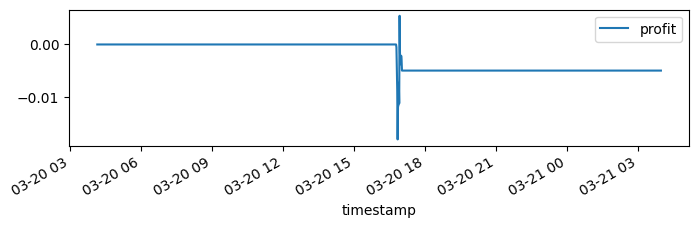

In [129]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.jitter_recovery.calculate_collective.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.06, +0.03, -0.01),
    collective_jump_recovery_trading_param = None,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

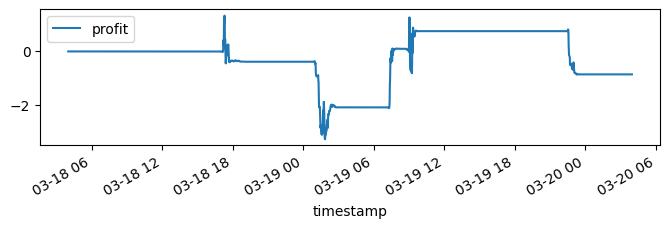

In [107]:
'''
trading_param = algo.collective_jitter_recovery.calculate.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.collective_jitter_recovery.calculate.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.03, +0.005, -0.01),
    collective_jump_recovery_trading_param = None,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

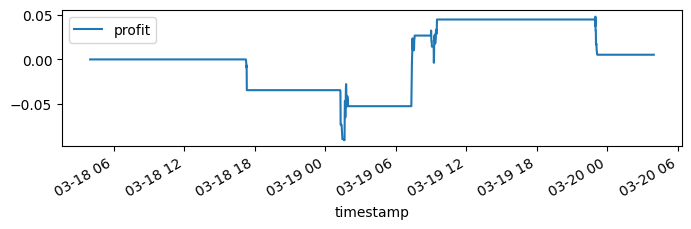

In [102]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.jitter_recovery.calculate_collective.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.06, +0.03, -0.01),
    collective_jump_recovery_trading_param = None,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

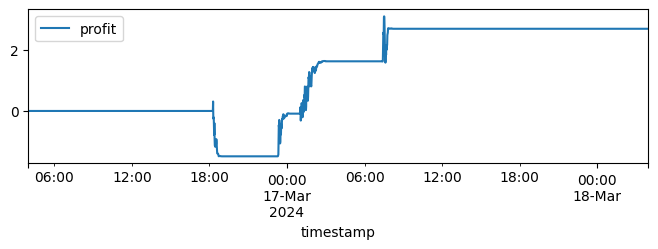

In [34]:
'''
trading_param = algo.collective_jitter_recovery.calculate.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.collective_jitter_recovery.calculate.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.03, +0.005, -0.01),
    collective_jump_recovery_trading_param = None,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

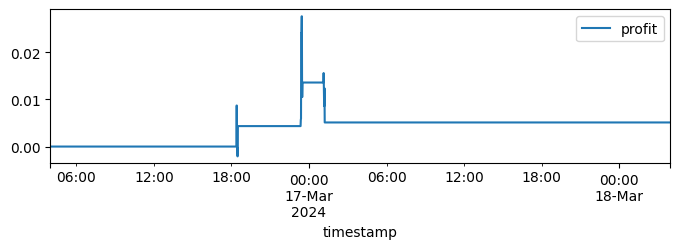

In [29]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.jitter_recovery.calculate_collective.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.06, +0.03, -0.01),
    collective_jump_recovery_trading_param = None,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

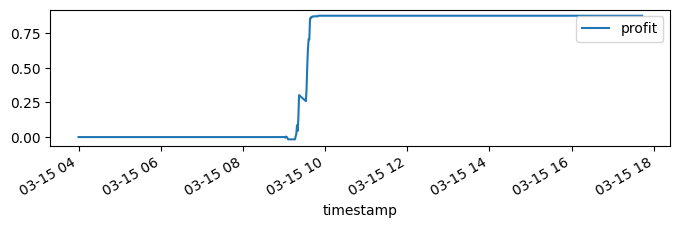

In [189]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.jitter_recovery.calculate_collective.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.06, +0.03, -0.01),
    collective_jump_recovery_trading_param = None,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

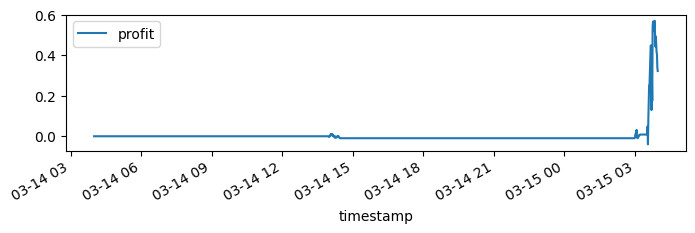

In [154]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.jitter_recovery.calculate_collective.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.06, +0.03, -0.01),
    collective_jump_recovery_trading_param = None,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

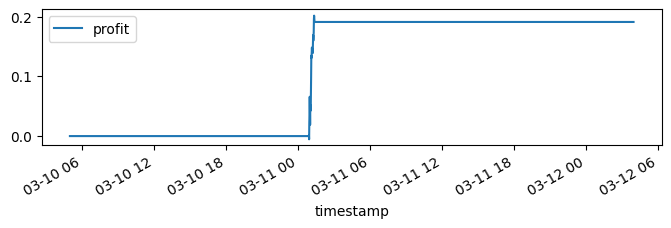

In [211]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.jitter_recovery.calculate_collective.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.06, +0.03, -0.01),
    collective_jump_recovery_trading_param = None,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

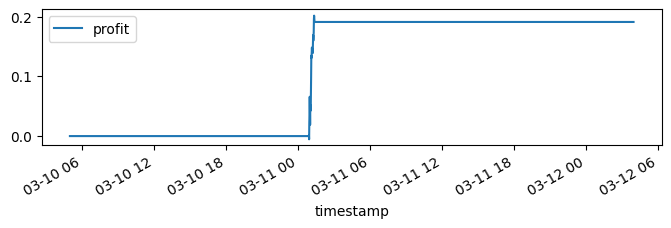

In [104]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.jitter_recovery.calculate_collective.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.06, +0.03, -0.01),
    collective_jump_recovery_trading_param = None,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

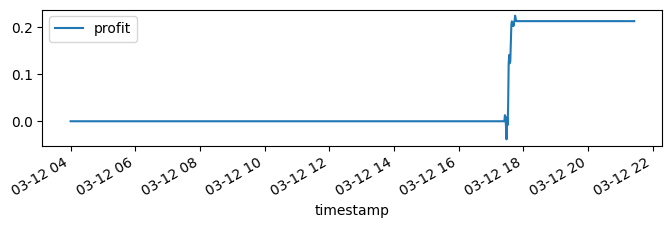

In [90]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.jitter_recovery.calculate_collective.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.06, +0.03, -0.01),
    collective_jump_recovery_trading_param = None,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

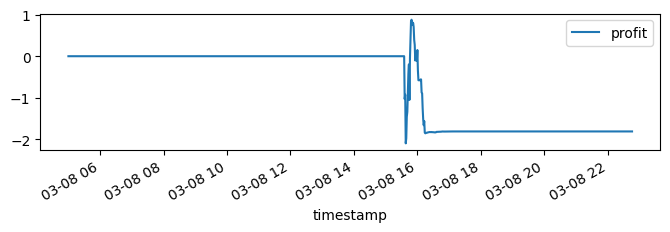

In [74]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.jitter_recovery.calculate_collective.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.03, +0.005, -0.01),
    collective_jump_recovery_trading_param = None,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

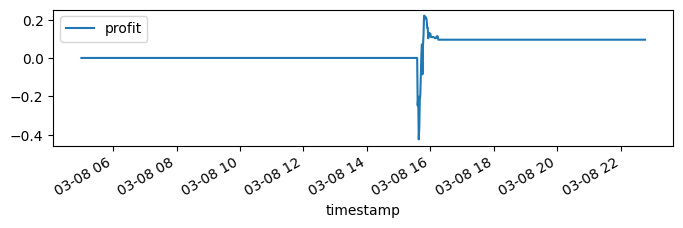

In [70]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.jitter_recovery.calculate_collective.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.06, +0.03, -0.01),
    collective_jump_recovery_trading_param = None,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

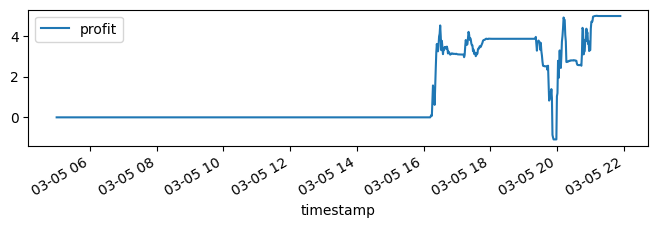

In [114]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    -0.03, -0.30, -0.03, +0.005, -0.01,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

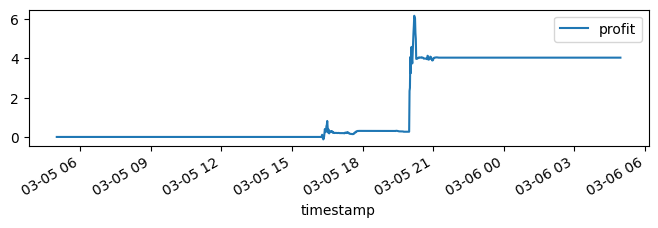

In [132]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    -0.03, -0.30, -0.06, +0.03, -0.01,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

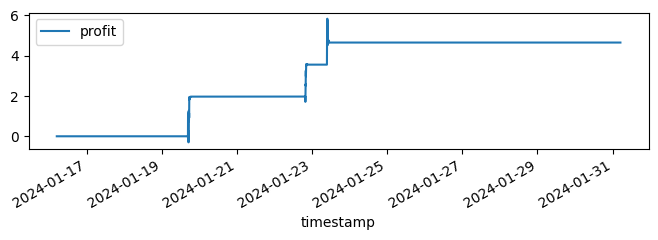

In [18]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    -0.03, -0.30, -0.03, +0.005, -0.01,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

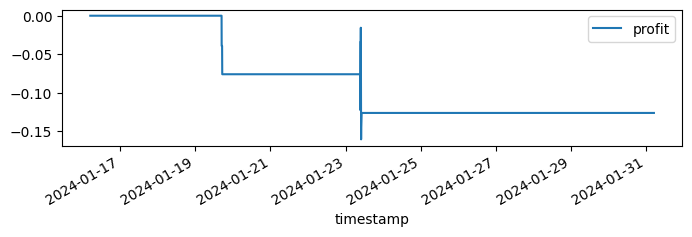

In [33]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.jitter_recovery.calculate_collective.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.03, +0.005, -0.01),
    collective_jump_recovery_trading_param = None,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

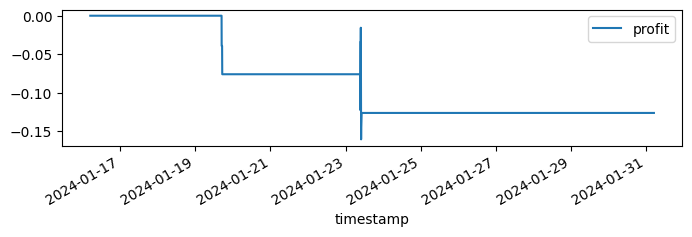

In [29]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.jitter_recovery.calculate_collective.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.06, +0.03, -0.01),
    collective_jump_recovery_trading_param = None,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

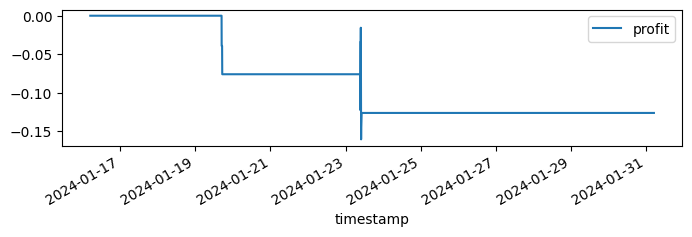

In [16]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    -0.03, -0.30, -0.06, +0.03, -0.01,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

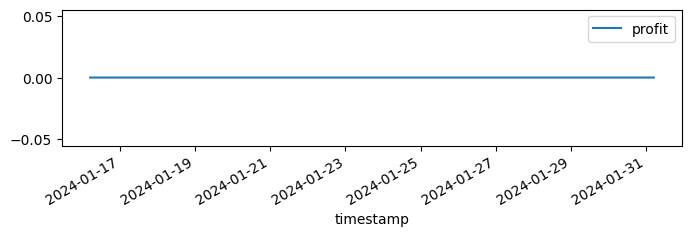

In [37]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = None,
    collective_jump_recovery_trading_param = algo.jitter_recovery.calculate_collective.CollectiveJumpRecoveryTradingParam(
        0.03, 0.15, 0.06, -0.03, 0.01),
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

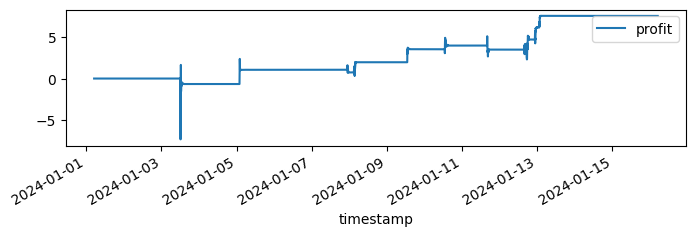

In [328]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    -0.03, -0.30, -0.03, +0.005, -0.01,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

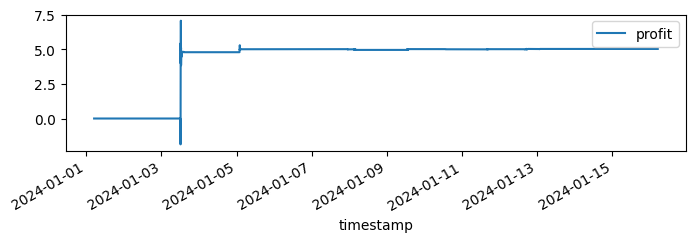

In [324]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    -0.03, -0.30, -0.06, +0.03, -0.01,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

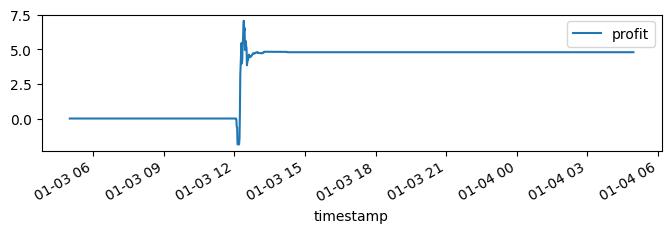

In [149]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = algo.jitter_recovery.calculate_collective.CollectiveDropRecoveryTradingParam(
        -0.03, -0.30, -0.06, +0.03, -0.01),
    collective_jump_recovery_trading_param = None,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

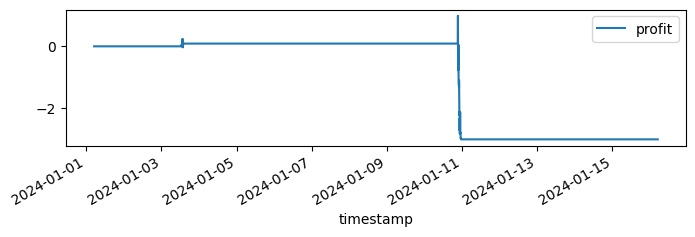

In [53]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = None,
    collective_jump_recovery_trading_param = algo.jitter_recovery.calculate_collective.CollectiveJumpRecoveryTradingParam(
        0.03, 0.15, 0.03, -0.005, 0.01),
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

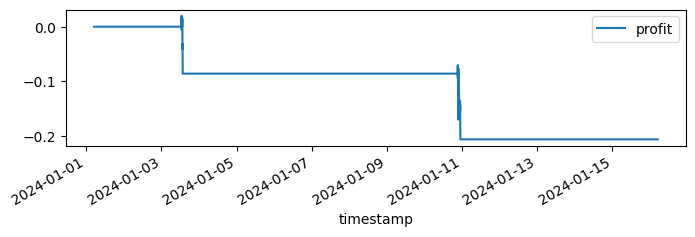

In [49]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    collective_drop_recovery_trading_param = None,
    collective_jump_recovery_trading_param = algo.jitter_recovery.calculate_collective.CollectiveJumpRecoveryTradingParam(
        0.03, 0.15, 0.06, -0.03, 0.01),
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

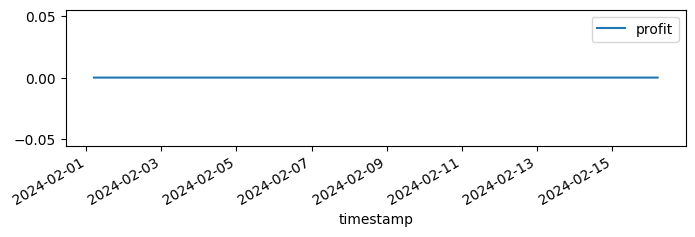

In [270]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    -0.03, -0.30, -0.03, +0.02, -0.01,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

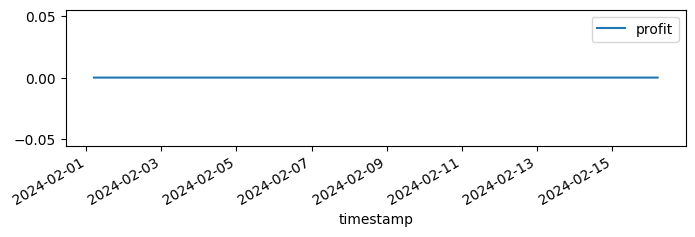

In [267]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    -0.03, -0.30, -0.06, +0.03, -0.01,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

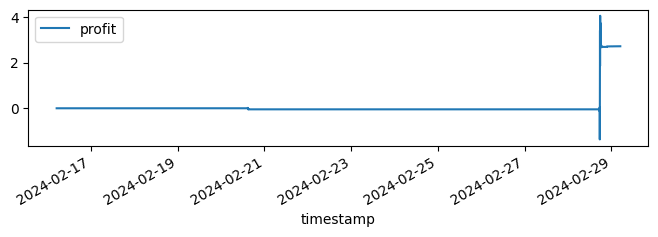

In [287]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    -0.03, -0.30, -0.03, +0.02, -0.01,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

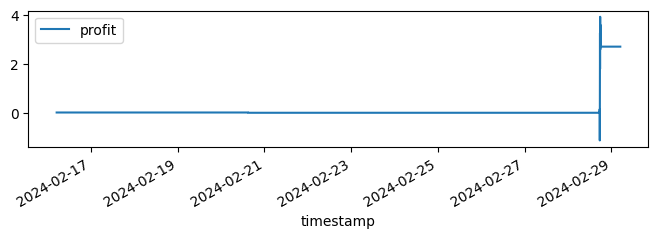

In [256]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    -0.03, -0.30, -0.06, +0.03, -0.01,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

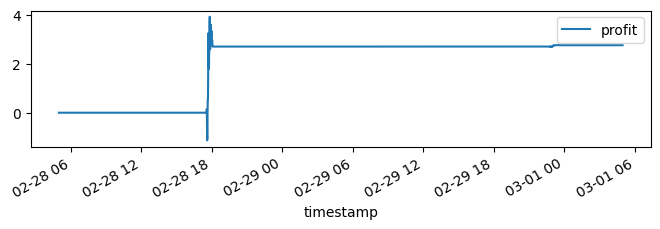

In [300]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    -0.03, -0.30, -0.06, +0.03, -0.01,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

<Axes: xlabel='timestamp'>

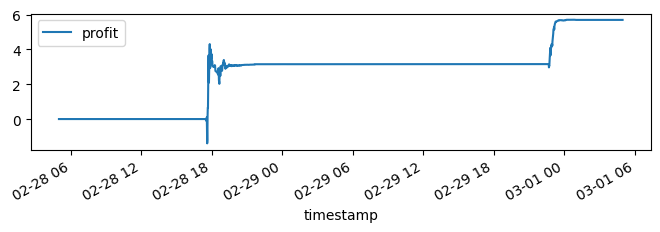

In [303]:
'''
trading_param = algo.jitter_recovery.calculate_collective.CollectiveRecoveryTradingParam(
    feature_param, 
    -0.03, -0.30, -0.03, +0.005, -0.01,
)
'''
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot(figsize=(8,2))

In [59]:
dfst_trading[dfst_trading.profit != 0][['profit']].dropna().groupby('symbol').sum().sort_values('profit')

,profit
symbol,
UNI-USDT-SWAP,-0.027251
RACA-USDT-SWAP,-0.007452
CTC-USDT-SWAP,-0.004424
CSPR-USDT-SWAP,-0.004212
LUNA-USDT-SWAP,-0.000880
...,...
LSK-USDT-SWAP,0.060188
WLD-USDT-SWAP,0.068084
BONK-USDT-SWAP,0.086268


<Axes: xlabel='timestamp'>

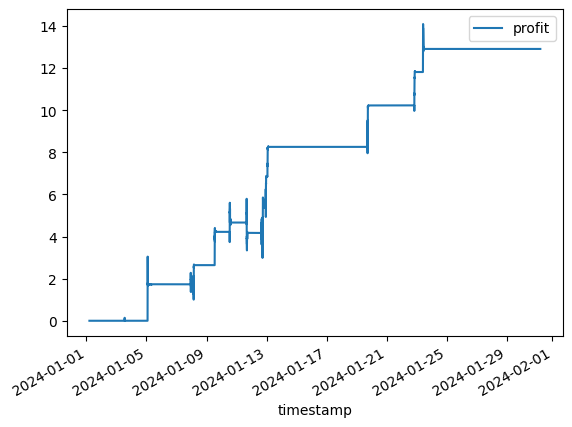

In [23]:
dfst_trading[['profit']].groupby('timestamp').sum().cumsum().plot()

In [35]:
collective_feature_columns_no_rolling = ['ch', 'ch_max', 'ch_min', 'ch_since_max', 'ch_since_min']
df_collective_feature = dfst_feature.dropna().groupby('timestamp')[collective_feature_columns_no_rolling].median().resample('1min').asfreq().ffill()
df_collective_feature['ch_window30_min'] = df_collective_feature.ch.rolling(window=30).min() 
df_collective_feature['ch_window30_max'] = df_collective_feature.ch.rolling(window=30).max() 
df_collective_feature['ch_window60_min'] = df_collective_feature.ch.rolling(window=60).min() 
df_collective_feature['ch_window60_max'] = df_collective_feature.ch.rolling(window=60).max() 

<Axes: xlabel='timestamp'>

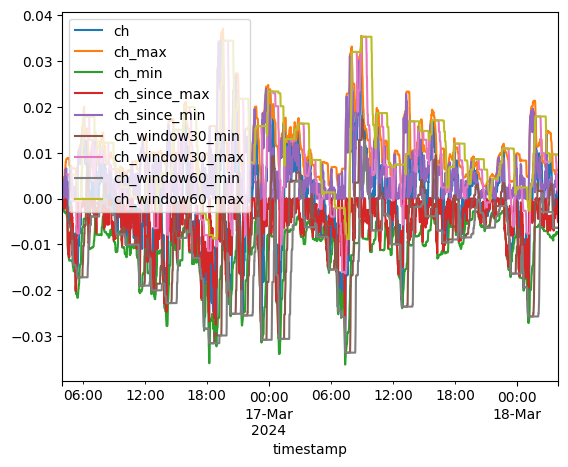

In [36]:
df_collective_feature.plot()

array([[<Axes: title={'center': 'profit'}>]], dtype=object)

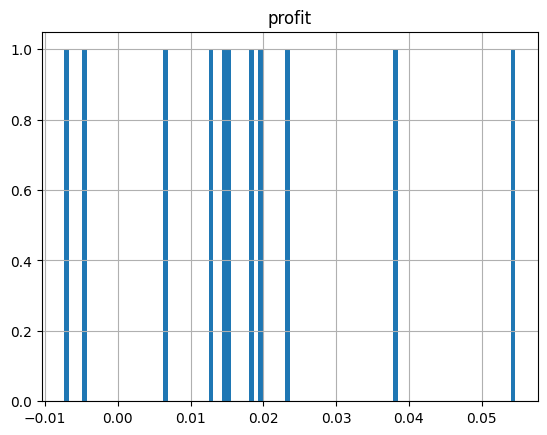

In [105]:
dfst_trading[dfst_trading.profit != 0][['profit']].dropna().groupby('symbol').sum().sort_values('profit').hist(bins=100)

In [615]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if 'PERP' not in row['symbol']: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-01-03 12:13:00, PERP-USDT-SWAP, 1.6581, position_changed: 1.0
2024-01-03 12:16:00, PERP-USDT-SWAP, 1.8838, position_changed: -1.0
2024-01-03 12:17:00, PERP-USDT-SWAP, 1.8575, position_changed: 1.0
2024-01-03 12:18:00, PERP-USDT-SWAP, 1.8033, position_changed: -1.0
2024-01-03 12:19:00, PERP-USDT-SWAP, 1.6796, position_changed: 1.0
2024-01-03 12:23:00, PERP-USDT-SWAP, 1.81, position_changed: -1.0
2024-01-03 12:24:00, PERP-USDT-SWAP, 1.8786, position_changed: 1.0
2024-01-03 12:25:00, PERP-USDT-SWAP, 1.801, position_changed: -1.0
2024-01-03 12:26:00, PERP-USDT-SWAP, 1.8229, position_changed: 1.0
2024-01-03 12:27:00, PERP-USDT-SWAP, 1.7579, position_changed: -1.0
2024-01-03 12:28:00, PERP-USDT-SWAP, 1.81, position_changed: 1.0
2024-01-03 12:29:00, PERP-USDT-SWAP, 1.8183, position_changed: -1.0


In [28]:
dfst_trading[dfst_trading.profit != 0][['profit']].dropna().groupby('symbol').sum().sort_values('profit')

,profit
symbol,
USTC-USDT-SWAP,-0.011166
ICP-USDT-SWAP,-0.010988
SSV-USDT-SWAP,-0.010349
ARB-USDT-SWAP,-0.000929
FET-USDT-SWAP,0.003337
INJ-USDT-SWAP,0.005184
ACE-USDT-SWAP,0.006177
LDO-USDT-SWAP,0.008632
PERP-USDT-SWAP,0.008839


In [41]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-01-03 13:14:00, ACE-USDT-SWAP, 8.439, position_changed: 1.0
2024-01-03 13:14:00, ICP-USDT-SWAP, 14.342, position_changed: 1.0
2024-01-03 13:14:00, LDO-USDT-SWAP, 3.128, position_changed: 1.0
2024-01-03 13:14:00, INJ-USDT-SWAP, 33.573, position_changed: 1.0
2024-01-03 13:14:00, PEOPLE-USDT-SWAP, 0.0178, position_changed: 1.0
2024-01-03 13:14:00, ORDI-USDT-SWAP, 76.4, position_changed: 1.0
2024-01-03 13:14:00, WSM-USDT-SWAP, 0.01654, position_changed: 1.0
2024-01-03 13:14:00, FET-USDT-SWAP, 0.6612, position_changed: 1.0
2024-01-03 13:14:00, SSV-USDT-SWAP, 27.92, position_changed: 1.0
2024-01-03 13:14:00, PERP-USDT-SWAP, 1.8153, position_changed: 1.0
2024-01-03 13:15:00, USTC-USDT-SWAP, 0.02776, position_changed: 1.0
2024-01-03 13:15:00, LDO-USDT-SWAP, 3.155, position_changed: -1.0
2024-01-03 13:15:00, PEOPLE-USDT-SWAP, 0.01848, position_changed: -1.0
2024-01-03 13:15:00, ARB-USDT-SWAP, 1.8717, position_changed: 1.0
2024-01-03 13:19:00, INJ-USDT-SWAP, 33.746, position_changed: -1.0
2

## single symobl

In [303]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.collective_jitter_recovery.calculate
importlib.reload(algo.collective_jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)
import algo.collective_jitter_recovery.research
importlib.reload(algo.collective_jitter_recovery.research)

<module 'algo.collective_jitter_recovery.research' from '/home/junlim/projects/jitter_recovery/algo/collective_jitter_recovery/research.py'>

In [299]:
symbol_investigate = 'PEPE-USDT-SWAP'
dfs = dfi.xs(symbol_investigate, level=1)

/home/junlim/projects/jitter_recovery/algo/collective_jitter_recovery/research.py:109: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  if i in df_collective_feature.index:


no trading happens


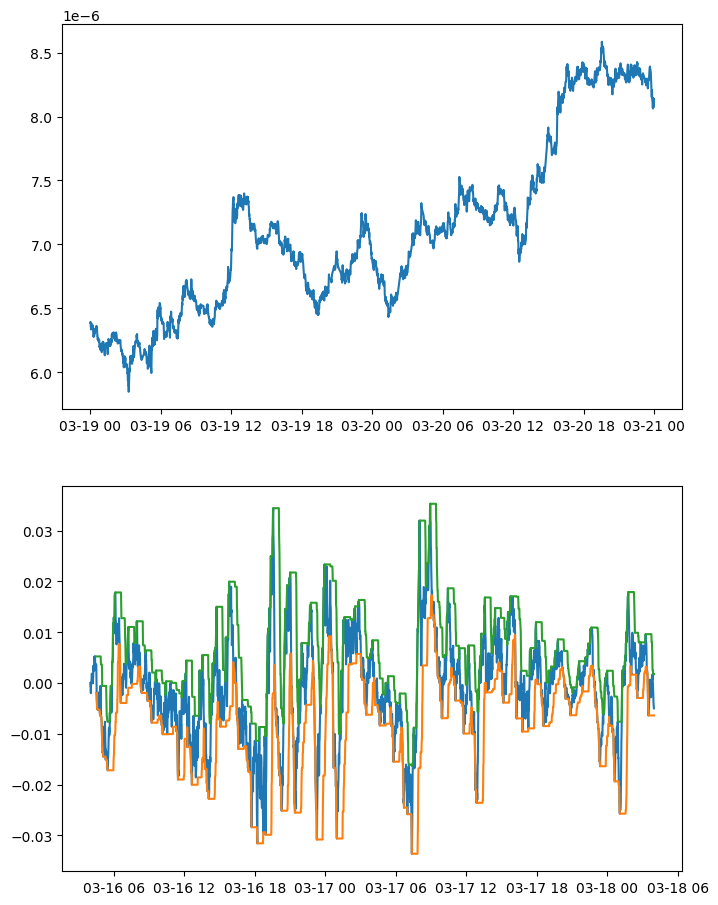

In [302]:
df_feature, df_trading = algo.collective_jitter_recovery.research.investigate_symbol(df, df_collective_feature, symbol_investigate, trading_param, figsize=(8, 11))

In [44]:
df_trading.columns

Index(['avg_v_before_max_ch', 'avg_v_before_min_ch', 'ch', 'ch_max', 'ch_min',
       'ch_since_max', 'ch_since_min', 'distance_max_ch', 'distance_min_ch',
       'v_ch_max_is_from', 'v_ch_max_is_to', 'v_ch_min_is_from',
       'v_ch_min_is_to', 'value', 'in_position', 'value_at_enter',
       'lowest_since_enter', 'highest_since_enter',
       'ch_from_lowest_since_enter', 'ch_from_highest_since_enter',
       'timedelta_since_position_enter', 'v_ch_max_is_to_when_enter',
       'v_ch_min_is_to_when_enter', 'v_ch_max_is_from_when_enter',
       'v_ch_min_is_from_when_enter', 'ch_from_enter', 'ch_collective',
       'ch_max_collective', 'ch_min_collective', 'ch_since_max_collective',
       'ch_since_min_collective', 'ch_window30_min_collective',
       'ch_window30_max_collective', 'ch_window60_min_collective',
       'ch_window60_max_collective', 'position_changed', 'profit_raw',
       'profit'],
      dtype='object')

<Axes: xlabel='timestamp'>

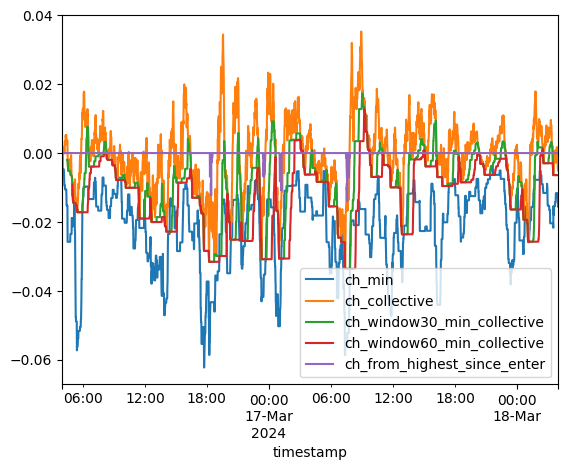

In [45]:
df_trading[['ch_min', 'ch_collective', 'ch_window30_min_collective', 'ch_window60_min_collective', 'ch_from_highest_since_enter']].plot()

In [577]:
df_trading[(df_trading.position_changed != 0)][['value', 'in_position', 'position_changed', 'profit_raw', 'profit']].dropna()

,value,in_position,position_changed,profit_raw,profit
timestamp,,,,,
2024-01-03 12:13:00,0.000265,1,1.0,0.000000,0.000000
2024-01-03 12:16:00,0.000258,0,-1.0,-0.000014,-0.052225
2024-01-03 12:17:00,0.000275,1,1.0,0.000000,0.000000
2024-01-03 12:19:00,0.000269,0,-1.0,-0.000015,-0.053502
2024-01-03 12:20:00,0.000279,1,1.0,0.000000,0.000000
2024-01-03 12:26:00,0.000283,0,-1.0,0.000008,0.029080
2024-01-03 12:27:00,0.000278,1,1.0,-0.000000,-0.000000
2024-01-03 12:32:00,0.000286,0,-1.0,-0.000004,-0.012440


In [578]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if row['symbol'] != symbol_investigate: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-01-03 12:13:00, TURBO-USDT-SWAP, 0.0002649, position_changed: 1.0
2024-01-03 12:16:00, TURBO-USDT-SWAP, 0.0002577, position_changed: -1.0
2024-01-03 12:17:00, TURBO-USDT-SWAP, 0.0002746, position_changed: 1.0
2024-01-03 12:19:00, TURBO-USDT-SWAP, 0.0002689, position_changed: -1.0
2024-01-03 12:20:00, TURBO-USDT-SWAP, 0.0002791, position_changed: 1.0
2024-01-03 12:26:00, TURBO-USDT-SWAP, 0.0002831, position_changed: -1.0
2024-01-03 12:27:00, TURBO-USDT-SWAP, 0.0002781, position_changed: 1.0
2024-01-03 12:32:00, TURBO-USDT-SWAP, 0.0002858, position_changed: -1.0
